In [87]:
## This script is to plot COLD temperature analysis for each location
## created by C. Bayu Risanto, S.J. (16 November 2023)
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import netCDF4 as nc
from netCDF4 import Dataset
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import colors
import matplotlib.dates as mdates
import matplotlib.colors as mplotcolors
import matplotlib.ticker as plticker
from datetime import date, datetime, timedelta
def read_nc(link,f):
    df = Dataset(link+f,'r')
    T2 = df.variables['T2'][:,:,:,:]
    time = df.variables['Times'][0,:,:]
    return T2,time

In [88]:
## read data and declare site of interest
dtst = datetime(2023,12,3)
dten = datetime(2024,1,12)
path = '/Users/luongtm/Documents/S2S/Sep-Forecast/NOV30_forecast/data/'
t2 = []
for isite in range(14):
    nf = 'Point.'+str(isite+1)+'.2023-11-30.nc'
    tt2,_ = read_nc(path,nf)
    t2.append(tt2)
T2 = np.asarray(t2)

## get time
_,time = read_nc(path,nf)

## convert to Celsius
Tc = T2 - 273.15

## location
fname = 'location_for_python.csv'
df = pd.read_csv(path+fname,usecols=[1])

nsite,nens,nt,ny,nx = Tc.shape
print(Tc.shape,)

(14, 51, 1105, 1, 1)


In [90]:
## calculate the probability here!!
## get days
ntd = 42; day0 = 3; tstart = day0*24; tend = tstart+ntd*24

## get thresholds
#thresh = np.arange(34,46,2) ## WARM
thresh = np.arange(0,21,4)   ## COLD

## get temperature data
T = Tc[:,:,tstart:tend,:,:]
ns,ne,nt,ny,nx = T.shape
T_res = np.reshape(T,(ns,ne,int(nt/24),24))
Tmax = T_res.max(axis=3)
Tmin = T_res.min(axis=3); print(Tmin.shape)

## get probability
prob_max = [[(Tmax[isite,:,:] > thresh[i]).sum(axis=0)/ne*100 for i in range(len(thresh))]for isite in range(14)]
prob_min = [[(Tmin[isite,:,:] < thresh[i]).sum(axis=0)/ne*100 for i in range(len(thresh))]for isite in range(14)]

## change here whether MIN or MAX (COLD or WARM)
prob = prob_min
PROB = np.asarray(prob)
PROB_int = np.transpose(PROB.astype(int),(0,2,1))
PROB_flip = np.flip(PROB_int,axis=2)
print(PROB_int.shape)

(14, 51, 42)
(14, 42, 6)


In [91]:
## time PROB
times = time[tstart:tend,:]
fixed = [[(times[xt][nt].decode('utf-8')) for nt in range(19)] for xt in range(1008)]
fixtime = np.asarray(fixed)
dhr = []
ct = 0
for it in range(int(nt/24)):
    ft = ''.join(fixtime[ct])
    dhr.append(ft)
    ct = ct + 24
days_hrsPR = np.asarray(dhr)
dateformPR = [datetime.fromisoformat(days_hrsPR[i])for i in range(int(nt/24))] ; #print(dateformPR)

In [116]:
## calculate center and bounds
SITE = 1
T1 = np.squeeze(T[SITE-1,:,:]) ; #print(T1.shape)
med = np.nanmedian(T1,axis=0) ; #print(med.shape)
prc = np.arange(0,110,20)
prclo = prc[0:int(len(prc)/2)]
prchi = prc[-1:int(len(prc)/2)-1:-1]; #print(prchi)
bndlo = np.percentile(T1,prclo,axis=0,interpolation='midpoint'); #print(bndlo.shape)
bndhi = np.percentile(T1,prchi,axis=0,interpolation='midpoint')

In [117]:
## calculate Tmedian Tmin Tmax of the ens mems
T_ensm = Tmin    ## change here whether MIN or MAX
Emedian = np.nanmedian(T_ensm,axis=1)
Emax = np.max(T_ensm,axis=1)
Emin = np.min(T_ensm,axis=1); print(Emedian.shape)

(14, 42)


In [118]:
## time
times = time[tstart:tend,:]; print(times.shape)
fixed = [[(times[xt][nt].decode('utf-8')) for nt in range(19)] for xt in range(1008)]
fixtime = np.asarray(fixed)
dhr = []
ct = 0
for it in range(int(nt)):
    ft = ''.join(fixtime[ct])
    dhr.append(ft)
    ct = ct + 1
days_hrs = np.asarray(dhr)
dateform = [datetime.fromisoformat(days_hrs[i])for i in range(int(nt))]


(1008, 19)


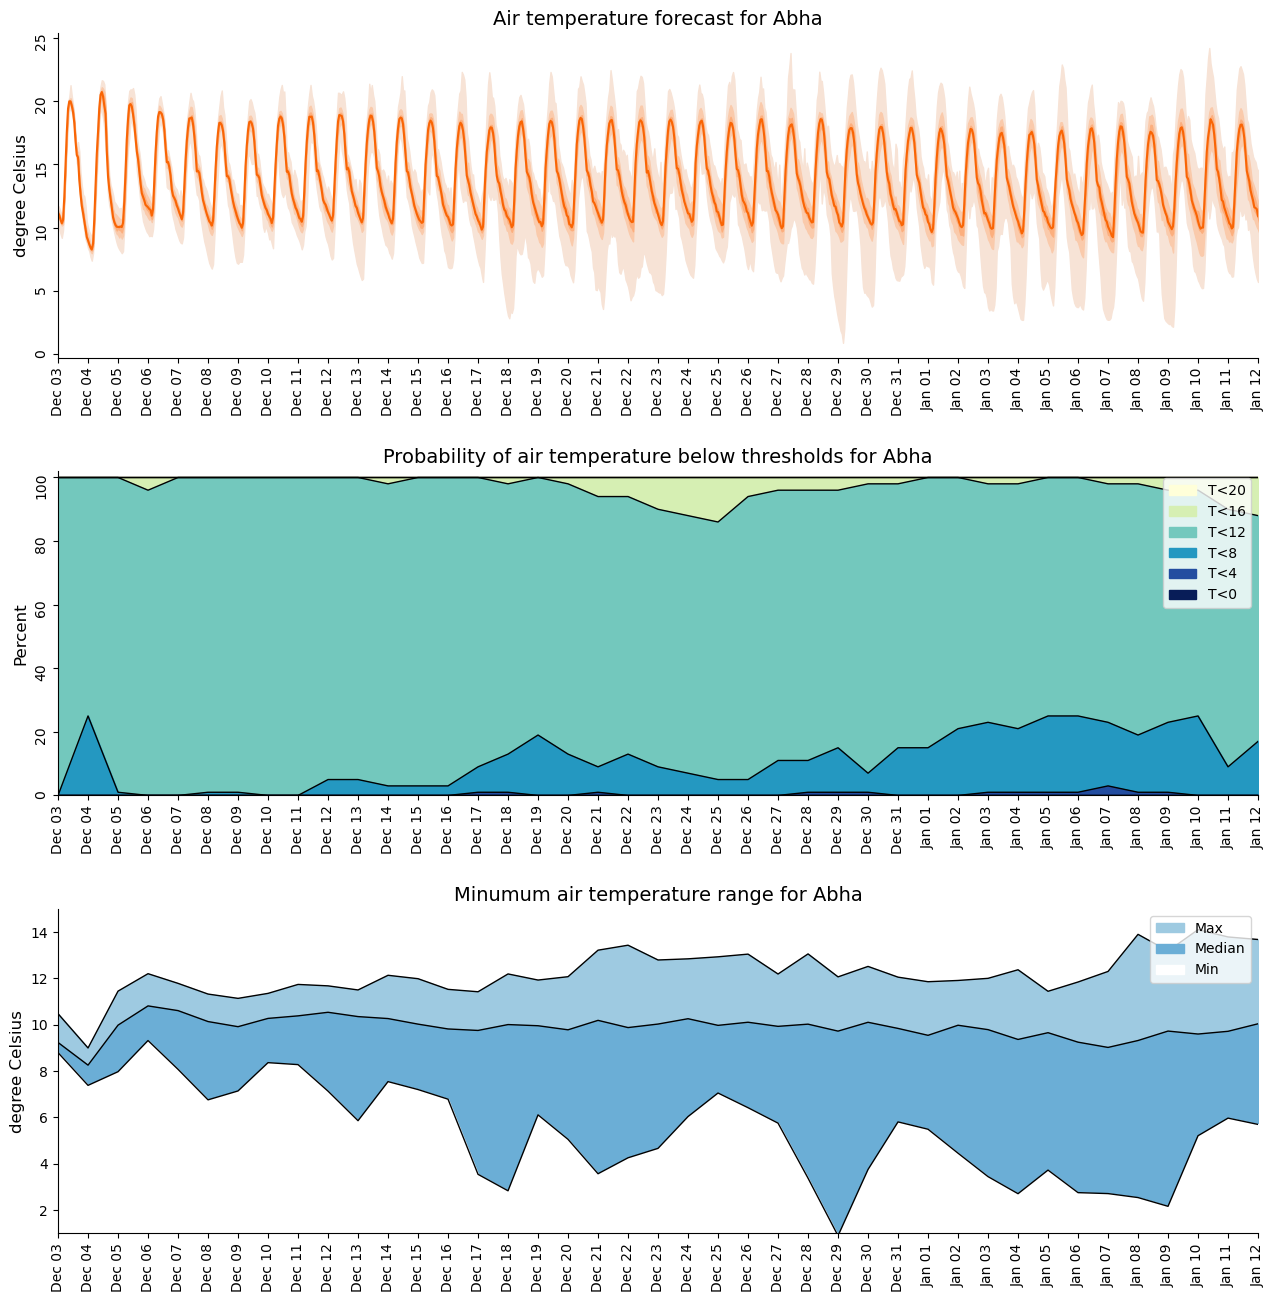

In [119]:
## set the color
# Blue
sample1 = ['#c3e4f3','#8fcff3','#5cb4da']
# Orange
sample1 = ['#f7e3d6','#facaab','#fcaf7e']
samp1 = mplotcolors.ListedColormap(sample1,'sample')
newcol1 = samp1(np.linspace(0,1,3))

## plot air temperature forecast
fig,(ax1,ax2,ax3) = plt.subplots(3, 1, figsize=(15, 15))
#ax1.plot(dateform,med,'#0b669a')
ax1.plot(dateform,med,'#f96505')
for i in range(3):
    ax1.fill_between(dateform,bndlo[i,:],bndhi[i,:],color=newcol1[i,:])
loc = plticker.MultipleLocator(base=1)
ax1.xaxis.set_major_locator(loc)
ax1.tick_params(labelrotation=90)
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
ax1.set_xlim([dtst, dten])  ## Need to change here according to the forecast run
ax1.set_ylabel('degree Celsius',fontsize=12)
ax1.spines[['right','top']].set_visible(False)
ax1.set_title('Air temperature forecast for '+df.values[SITE-1][0],fontsize=14)

## set the color
sample2 = plt.cm.get_cmap('YlGnBu',6)
newcol2 = sample2(np.linspace(0,1,6))

## plot probability of air temperature below threshold
for i in range(6):
    if i <= 4:
        ax2.fill_between(dateformPR,PROB_flip[SITE-1,:,i],PROB_flip[SITE-1,:,i+1],color=newcol2[i,:])
    else:
        ax2.fill_between(dateformPR,PROB_flip[SITE-1,:,i],0,color=newcol2[i,:])
for i in range(6):
    ax2.plot(dateformPR,PROB_flip[SITE-1,:,i],'k',linewidth=1)
        
loc = plticker.MultipleLocator(base=1)
ax2.xaxis.set_major_locator(loc)
ax2.tick_params(labelrotation=90)
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
ax2.set_xlim([dtst, dten]) ## Need to change here according to the forecast run
ax2.set_ylim([0,102])
ax2.legend(['T<20','T<16','T<12','T<8','T<4','T<0'],loc='upper right')
ax2.set_ylabel('Percent',fontsize=12)
ax2.spines[['right','top']].set_visible(False)
ax2.set_title('Probability of air temperature below thresholds for '+df.values[SITE-1][0],fontsize=14)

## set the color
sample3 = plt.cm.get_cmap('tab20c',20)
newcol3 = sample3(np.linspace(0,1,20))

## plot minimum temperature range
ax3.fill_between(dateformPR,Emax[SITE-1,:],Emedian[SITE-1,:],color=newcol3[2,:])
ax3.fill_between(dateformPR,Emedian[SITE-1,:],Emin[SITE-1,:],color=newcol3[1,:])
ax3.fill_between(dateformPR,Emin[SITE-1,:],np.rint(Emin[SITE-1,:].min()),color='#ffffff')
ax3.plot(dateformPR,Emax[SITE-1,:],'k',linewidth=1)
ax3.plot(dateformPR,Emedian[SITE-1,:],'k',linewidth=1)
ax3.plot(dateformPR,Emin[SITE-1,:],'k',linewidth=1)

loc = plticker.MultipleLocator(base=1)
ax3.xaxis.set_major_locator(loc)
plt.xticks(rotation=90)
ax3.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
ax3.set_xlim([dtst, dten]) ## Need to change here according to the forecast run
ax3.set_ylim([np.rint(Emin[SITE-1,:].min()),np.rint(Emax[SITE-1,:].max())+1])
ax3.legend(['Max','Median','Min'],loc='upper right')
ax3.set_ylabel('degree Celsius',fontsize=12)
ax3.spines[['right','top']].set_visible(False)
ax3.set_title('Minumum air temperature range for '+df.values[SITE-1][0],fontsize=14)

#fig.tight_layout()
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.0, 
                    hspace=0.35)
## SAVE
dir_out = '/Users/luongtm/Documents/S2S/Sep-Forecast/NOV30_forecast/'
plotfile  = 'T2_cold_20231130.'+df.values[SITE-1][0]+'.png'
sf = fig.savefig(dir_out+plotfile, dpi=300, bbox_inches='tight')

## show and close
plt.show()
plt.close()